In [1]:

import numpy as np
import matplotlib.pyplot as plt

In [2]:


state_dim = 4
measurement_dim = 2
timesteps = 40
landmarks = np.array([[5, 5], [-5, 5]]) 
dt = 0.5 
R = 0.1 * np.eye(2)  
Q = 0.5 * np.eye(2)  
x = np.array([0, 0, 1, 0])  # Initial state [p_x, p_y, v_x, v_y]
P = np.eye(state_dim)

# moving in 4 directions as given by question 
velocity_li =[]
velocity_li = velocity_li + [(1, 0)]*10 
velocity_li = velocity_li + [(0, -1)]*10 
velocity_li = velocity_li + [(-1, 0)]*10
velocity_li = velocity_li + [(0,1)]*10 

Jac = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])



In [3]:

estimated_positions = []
state_prediction =[] 

for tmp in range(timesteps):
    
    v_x, v_y = velocity_li[tmp]
    x[2], x[3] = v_x, v_y
    x = Jac @ x  # State prediction
    state_prediction.append(x)
    P = Jac @ P @ Jac.T + np.block([[R, np.zeros((2, 2))], [np.zeros((2, 2)), np.zeros((2, 2))]])  

    # Measurement Prediction Step
    z_pred = np.array([np.linalg.norm(x[:2] - landmarks[0]), np.linalg.norm(x[:2] - landmarks[1])])
    Jac_measure = np.zeros((measurement_dim, state_dim)) 
    for i, (lx, ly) in enumerate(landmarks):
        Jac_measure[i, 0] = x[0] - lx / np.sqrt( (x[0] - lx)**2 + (x[1] - ly)**2)
        Jac_measure[i, 1] = x[1] - ly / np.sqrt((x[0] - lx)**2 + (x[1] - ly)**2)

    K = P @ Jac_measure.T @ np.linalg.inv(Jac_measure @ P @ Jac_measure.T + Q)
    measurement_epislon_noise = np.random.multivariate_normal(np.zeros(measurement_dim), Q)
    # 2nd version of the kalman eqn used taught in class 
    z = z_pred + measurement_epislon_noise  
    x = x + K @ (z - z_pred) 
    P = (np.eye(state_dim) - K @ Jac_measure) @ P  
    estimated_positions.append(x[:2]) #x,y




In [4]:
estimated_positions = np.array(estimated_positions)
state_prediction =np.array(state_prediction)

In [5]:
true_positions = []
x_true = np.array([0.0, 0.0])  

for vel in velocity_li:
    x_true += np.array(vel) * dt  
    true_positions.append(x_true.copy())
    
true_positions = np.array(true_positions)
estimated_positions = np.array(estimated_positions)
sigma_bounds = 3 * np.sqrt(np.diag(P)[:2])  


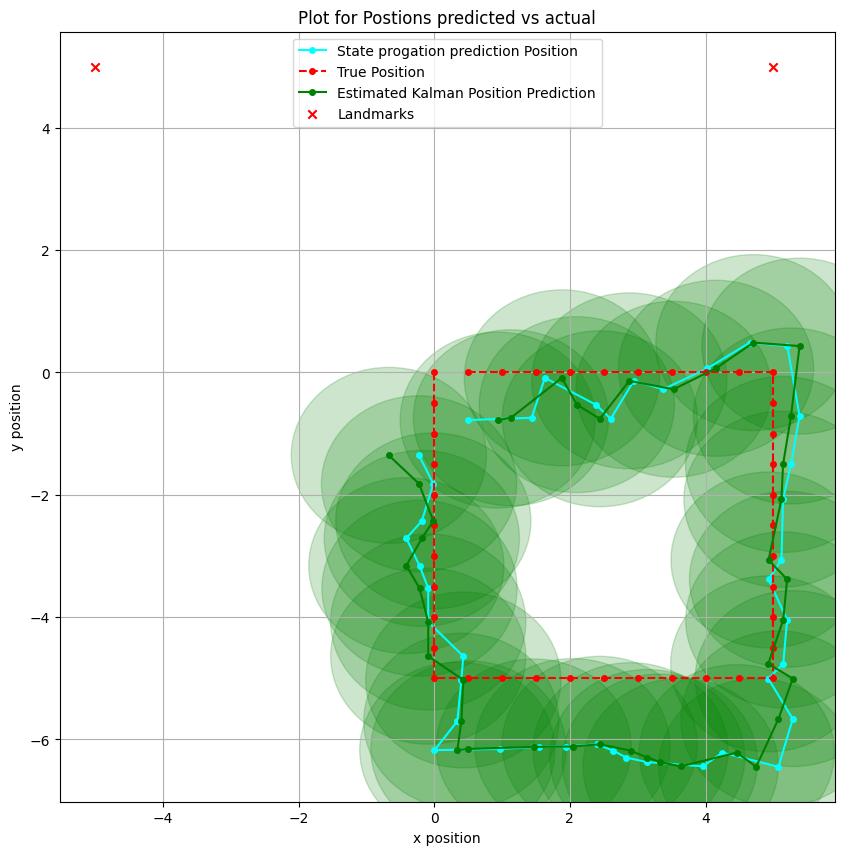

In [6]:

plt.figure(figsize=(10, 10))
plt.plot(state_prediction[:, 0], estimated_positions[:, 1], label="State progation prediction Position", color="cyan", marker="o", markersize=4)
plt.plot(true_positions[:, 0], true_positions[:, 1], label="True Position", linestyle="--", color="red", marker="o", markersize=4)
plt.plot(estimated_positions[:, 0], estimated_positions[:, 1], label="Estimated Kalman Position Prediction", color="green", marker="o", markersize=4)
for i in range(len(estimated_positions)):
    ellipse = plt.Circle((estimated_positions[i, 0], estimated_positions[i, 1]), sigma_bounds[0], color='green', alpha=0.2)
    plt.gca().add_artist(ellipse)

plt.scatter(landmarks[:, 0], landmarks[:, 1], color="red", label="Landmarks", marker="x")
plt.title("Plot for Postions predicted vs actual")
plt.xlabel("x position")
plt.ylabel("y position")
plt.legend()
plt.grid()
plt.show()

In [7]:

def estimate_correspondences(X, Y, t, R, d_max):
    X_transformed = (R @ X.T).T + t  
    correspondences = []
    for i, x in enumerate(X_transformed):
        distances = np.linalg.norm(Y - x, axis=1)
        j = np.argmin(distances)
        if distances[j] <= d_max:
            correspondences.append((i, j))
    
    return correspondences

In [14]:

def compute_optimal_rigid_registration(X, Y, Correspondence):
    
    #print(X.shape,Y.shape)
    
    PtX_corr = np.array([X[i] for i, j in Correspondence])
    PtY_corr = np.array([Y[j] for i, j in Correspondence])
    
    #print(X_corr.shape,Y_corr.shape)
    X_centroid = np.mean(PtX_corr, axis=0)
    Y_centroid = np.mean(PtY_corr, axis=0)
    
    #print(X_centroid.shape,Y_centroid.shape)
    
    X_centered = PtX_corr - X_centroid
    Y_centered = PtY_corr - Y_centroid
    
    H = X_centered.T @ Y_centered
    
    #print( "H matrix:", H , H.shape)
    
    U, S, Vt = np.linalg.svd(H)
    Rotmat = Vt.T @ U.T
    
    
    if np.linalg.det(Rotmat) < 0: # Here R should be positive definite
        Vt[-1, :] *= -1
        Rotmat = Vt.T @ U.T
        
    translation = Y_centroid - Rotmat @ X_centroid
    
    return Rotmat, translation


In [15]:

def icp(X, Y, t0, R0, d_max, num_icp_iters, tolerance=1e-6):
    
    t_final = t0
    R_final = R0
    
    for iteration in range(num_icp_iters):
        correspondences = estimate_correspondences(X, Y, t_final, R_final, d_max)    
        R_opt, t_opt = compute_optimal_rigid_registration(X, Y, correspondences)
        delta_R = R_opt @ R_final - R_final
        delta_t = t_opt - t_final
        if np.linalg.norm(delta_R) < tolerance and np.linalg.norm(delta_t) < tolerance:
            # early convergence condition
            break
        
        R_final = R_opt 
        t_final = t_opt
    
    return R_final, t_final

In [16]:
def load_point_cloud_np(file_path):
    point_cloud = np.loadtxt(file_path)
    return np.array(point_cloud)

In [17]:

X = load_point_cloud_np('pclX.txt')
Y = load_point_cloud_np('pclY.txt')

X.shape
Y.shape

(5750, 3)

In [18]:
def compute_rmse(X, Y, correspondences, R_est, t_est):
    
    errors = []
    
    for i, j in correspondences:
        transformed_point = R_est @ X[i] + t_est
        error = np.linalg.norm(transformed_point - Y[j])
        errors.append(error ** 2)
    rmse = np.sqrt(np.mean(errors))
    return rmse

In [19]:
#compute_rmse([1,1,1],[0,0,0],[(1,1),(2,2),(0,0)],np.eye(3),np.zeros(3)) check 

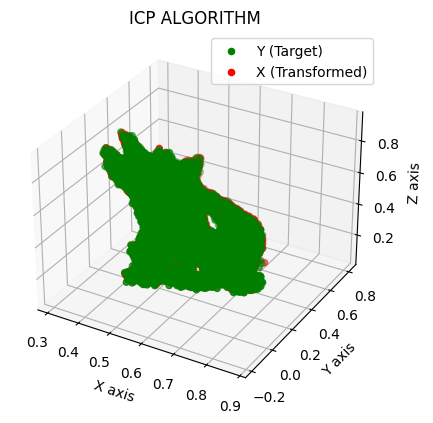

Estimated Trans Vector (t):
 [ 0.49661487 -0.29392971  0.29645004]
Estimated Rotation Matrix (R):
 [[ 0.95126601 -0.15043058 -0.26919069]
 [ 0.22323628  0.9381636   0.26460276]
 [ 0.21274056 -0.31180074  0.92602471]]
(RMSE): 0.008500463240691907


In [20]:

t0 = np.zeros(3)
R0 = np.eye(3)
d_max = 0.25
num_icp_iters = 30

Rotmat_estimated, translation_estimated = icp(X,Y, t0, R0, d_max, num_icp_iters)

transformed_X = (Rotmat_estimated @ X.T).T + translation_estimated
final_correspondences = estimate_correspondences(X, Y, translation_estimated, Rotmat_estimated, d_max)
rmse = compute_rmse(X, Y, final_correspondences, Rotmat_estimated, translation_estimated)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], color='green', label='Y (Target)')
ax.scatter(transformed_X[:, 0], transformed_X[:, 1], transformed_X[:, 2], color='red', label='X (Transformed)')
ax.set_xlabel('X axis ')
ax.set_ylabel('Y axis ')
ax.set_zlabel('Z axis')
ax.legend()
plt.title("ICP ALGORITHM")
plt.show()
print("Estimated Trans Vector (t):\n", translation_estimated)
print("Estimated Rotation Matrix (R):\n", Rotmat_estimated)
print("(RMSE):", rmse)



In [21]:
from scipy.linalg import expm

In [22]:
# Question 3c

def pf_propagation(t1, Xt1, phi_dot_l, phi_dot_r, t2, r, w, sigma_l, sigma_r):
    
    Xt2 = []
    delta_t = t2 - t1
    for x, y, theta in Xt1:
        phi_l = phi_dot_l + np.random.normal(0, sigma_l)
        phi_r = phi_dot_r + np.random.normal(0, sigma_r)
        velocity_tangents = np.array([
            [0, -r / w * (phi_r - phi_l), r * (phi_r + phi_l) / 2],
            [r / w * (phi_r - phi_l), 0, 0],
            [0, 0, 0]
        ])
        # Now we have to move on the lie group so 
        # first we build SE2 lie element 
        lie_element_X = np.array([
            [np.cos(theta), -np.sin(theta), x],
            [np.sin(theta), np.cos(theta), y],
            [0, 0, 1]
        ])
        # Now we move on the curve using exponential curve 
        lie_element_Y = lie_element_X @ expm(delta_t * velocity_tangents)
        
        #extract state from lie element Y now [x,y,thetha]
        x_new = lie_element_Y[0, 2] # x
        y_new = lie_element_Y[1, 2] # y 
        theta_new = np.arctan2(lie_element_Y[1, 0], lie_element_Y[1, 1])
        
        Xt2.append([x_new, y_new, theta_new])
    
    return np.array(Xt2)

In [23]:

def pf_update(Xt, zt, sigma_p):
    weights = np.zeros(len(Xt))
    measurement_variance = sigma_p**2
    
    for i, (x, y, theta) in enumerate(Xt):
        distance = np.array([x, y]) - zt
        weights[i] = np.exp(-0.5 * np.dot(distance, distance) / measurement_variance) / (2 * np.pi * measurement_variance)

    weights /= np.sum(weights)
    
    indices = np.random.choice(len(Xt), size=len(Xt), p=weights)
    X_bar_t = Xt[indices]
    
    return X_bar_t

In [24]:

phi_dot_l = 1.5
phi_dot_r = 2
r = 0.25
w = 0.5
sigma_l = 0.05
sigma_r = 0.05
sigma_p = 0.10
t0 = 0
t10 = 10
N = 1000

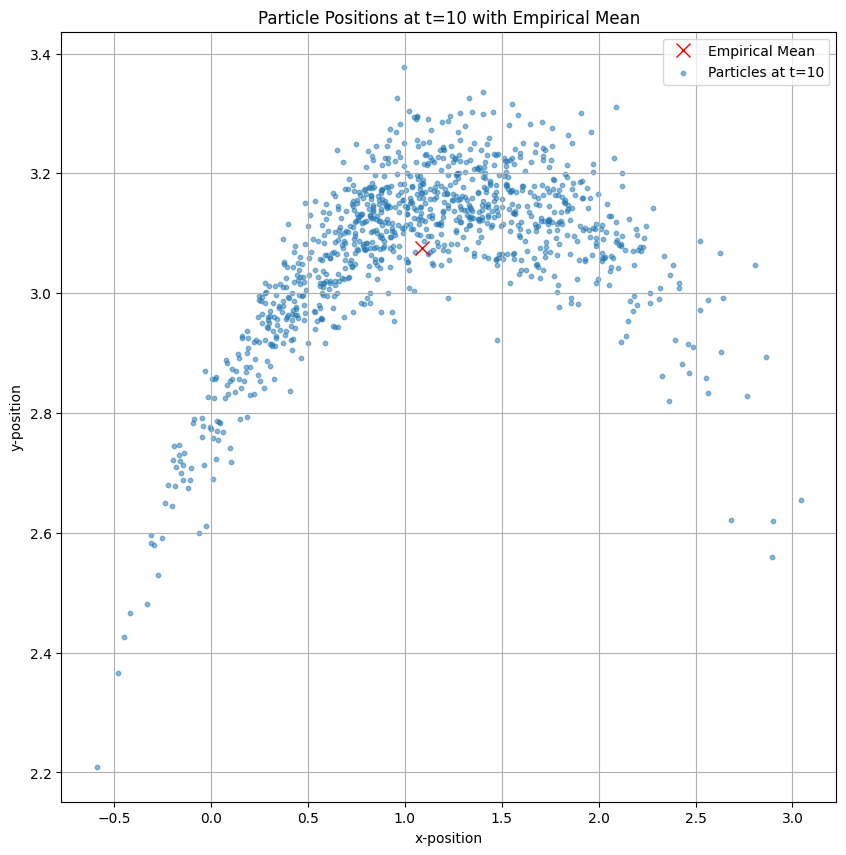

Empirical Mean: [1.09082685 3.07542669]
Empirical Covariance:
 [[0.40439737 0.0412272 ]
 [0.0412272  0.01961431]]


In [25]:
# ques 3e
Xt0 = np.zeros((N, 3))
Xt10 = pf_propagation(t0, Xt0, phi_dot_l, phi_dot_r, t10, r, w, sigma_l, sigma_r)

positions = Xt10[:, :2] 
empirical_mean = np.mean(positions, axis=0)
empirical_covariance = np.cov(positions, rowvar=False)

plt.figure(figsize=(10, 10))
plt.plot(empirical_mean[0], empirical_mean[1], 'rx', markersize=10, label="Empirical Mean")

plt.scatter(positions[:, 0], positions[:, 1], s=10, alpha=0.5, label="Particles at t=10")
plt.ylabel("y-position")
plt.xlabel("x-position")

plt.title("Particle Positions at t=10 with Empirical Mean")
plt.legend()
plt.grid(True)
plt.show()

# Output empirical mean and covariance
print("Empirical Mean:", empirical_mean)
print("Empirical Covariance:\n", empirical_covariance)


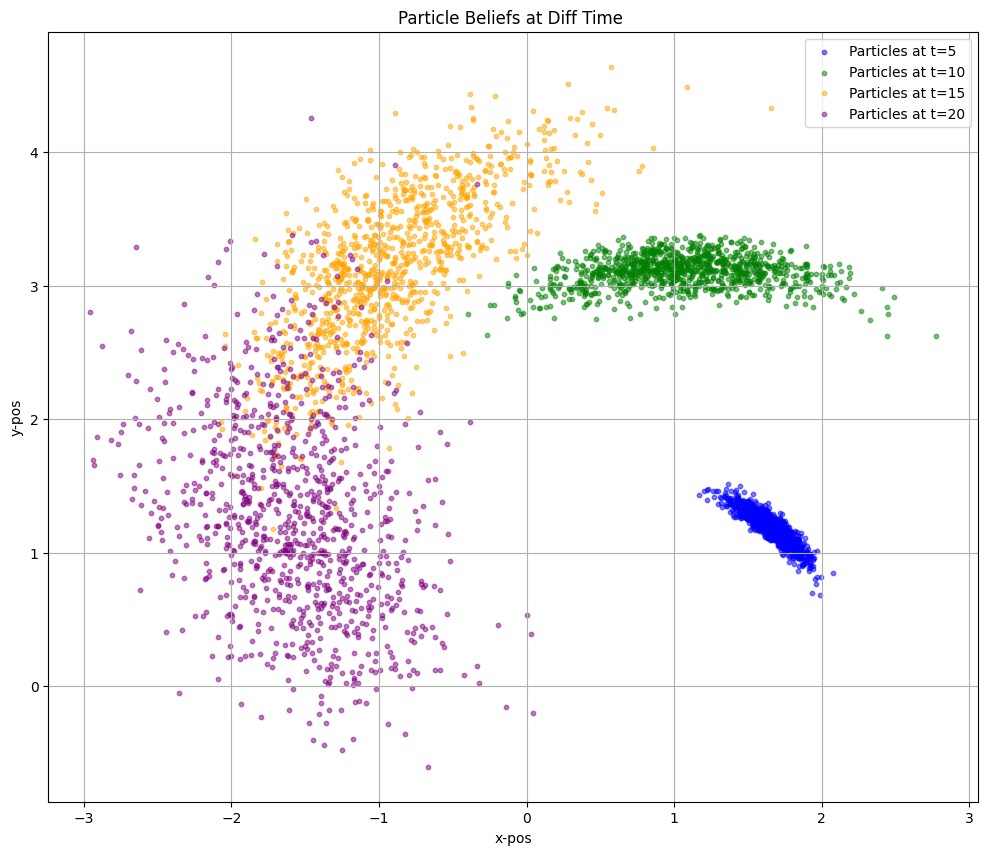

Time Step t=5:
  Mean: [1.65223    1.18903928]
  Covariance:
[[ 0.01987589 -0.01568978]
 [-0.01568978  0.01555136]]

Time Step t=10:
  Mean: [1.05339562 3.103894  ]
  Covariance:
[[0.24562188 0.00434806]
 [0.00434806 0.0144625 ]]

Time Step t=15:
  Mean: [-0.92137629  3.13363496]
  Covariance:
[[0.26814519 0.2103992 ]
 [0.2103992  0.32633541]]

Time Step t=20:
  Mean: [-1.56934705  1.29334721]
  Covariance:
[[ 0.23192936 -0.11050225]
 [-0.11050225  0.58695453]]



In [26]:
# ques 3f
time_ = [5, 10, 15, 20]
Xt = np.zeros((N, 3))
particle_sets = []
empirical_means = []
empirical_covariances = []

for t in time_:
    Xt = pf_propagation(t-5, Xt, phi_dot_l, phi_dot_r, t, r, w, sigma_l, sigma_r) # ToDO (PArth ) : bad conditioning  remove t-5 
    particle_sets.append(Xt)
    positions = Xt[:, :2]  
    empirical_mean = np.mean(positions, axis=0)
    empirical_covariance = np.cov(positions, rowvar=False)
    
    empirical_means.append(empirical_mean)
    empirical_covariances.append(empirical_covariance)


plt.figure(figsize=(12, 10))
colors = ['blue', 'green', 'orange', 'purple']
for i, t in enumerate(time_):
    positions = particle_sets[i][:, :2]  
    plt.scatter(positions[:, 0], positions[:, 1], s=10, alpha=0.5, label=f"Particles at t={t}", color=colors[i])

plt.xlabel("x-pos")
plt.ylabel("y-pos")
plt.title("Particle Beliefs at Diff Time ")
plt.legend()
plt.grid(True)
plt.show()

# Print empirical means and covariances
for i, t in enumerate(time_):
    print(f"Time Step t={t}:")
    print(f"  Mean: {empirical_means[i]}")
    print(f"  Covariance:\n{empirical_covariances[i]}\n")


In [27]:
time_ = [5, 10, 15, 20]
measurements = np.array([
    [1.6561, 1.2847],
    [1.0505, 3.1059],
    [-0.9875, 3.2118],
    [-1.6450, 1.1978]
])

Xt = np.zeros((N, 3))

particle_sets_updated = []
empirical_means_updated = []
empirical_covariances_updated = []

for i, t in enumerate(time_):
    
    Xt_propagated = pf_propagation(t-5, Xt, phi_dot_l, phi_dot_r, t, r, w, sigma_l, sigma_r)
    Xt_updated = pf_update(Xt_propagated, measurements[i], sigma_p)
    
    Xt = Xt_updated
    
    particle_sets_updated.append(Xt)    
    positions = Xt[:, :2]  
    empirical_mean = np.mean(positions, axis=0)
    empirical_covariance = np.cov(positions, rowvar=False)
    
    empirical_means_updated.append(empirical_mean)
    empirical_covariances_updated.append(empirical_covariance)



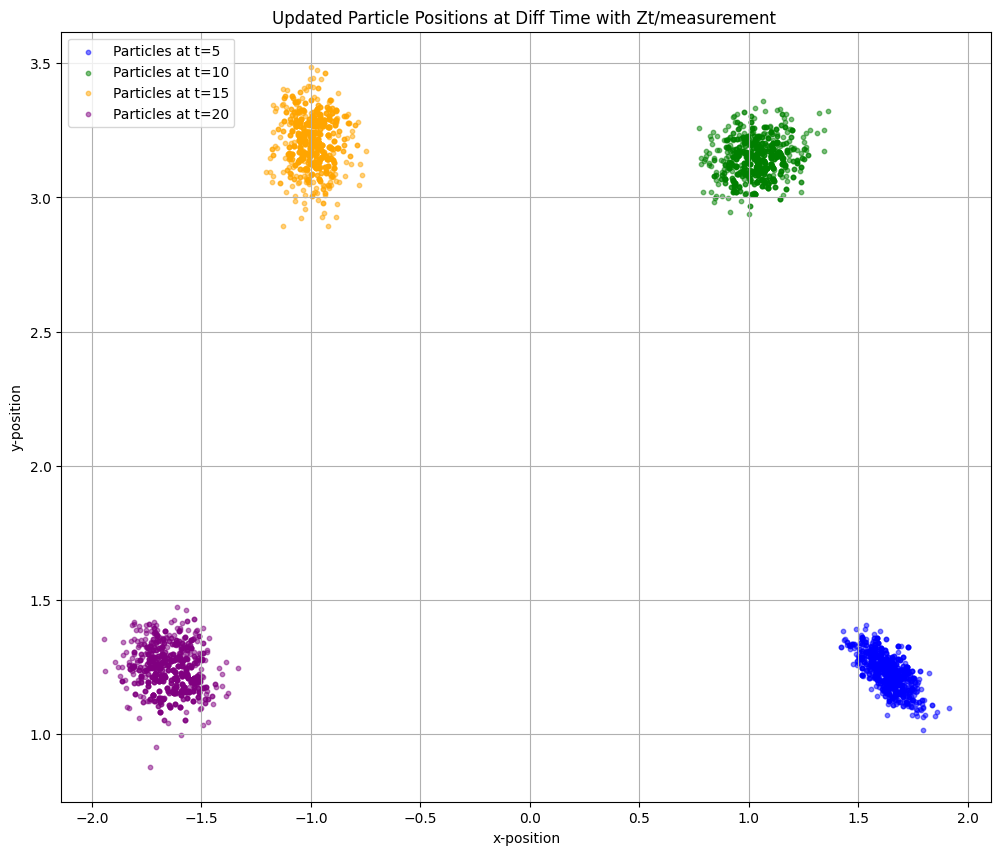

Time Step  t=5:
  Mean: [1.63371656 1.23088   ]
  Covariance:
[[ 0.00514214 -0.00298717]
 [-0.00298717  0.00392195]]

Time Step  t=10:
  Mean: [1.03699585 3.14266508]
  Covariance:
[[0.00858679 0.00088405]
 [0.00088405 0.0044851 ]]

Time Step  t=15:
  Mean: [-0.9936104   3.21085317]
  Covariance:
[[ 0.00498619 -0.00022687]
 [-0.00022687  0.00821717]]

Time Step  t=20:
  Mean: [-1.64236408  1.23881975]
  Covariance:
[[ 0.00842608 -0.00091436]
 [-0.00091436  0.00621654]]



In [29]:
plt.figure(figsize=(12, 10))
colors = ['blue', 'green', 'orange', 'purple']
for i, t in enumerate(time_):
    positions = particle_sets_updated[i][:, :2]  # x, y positions
    plt.scatter(positions[:, 0], positions[:, 1], s=10, alpha=0.5, label=f"Particles at t={t}", color=colors[i])

plt.xlabel("x-position")
plt.ylabel("y-position")
plt.title("Updated Particle Positions at Diff Time with Zt/measurement ")
plt.legend()
plt.grid(True)
plt.show()

for i, t in enumerate(time_):
    print(f"Time Step  t={t}:")
    print(f"  Mean: {empirical_means_updated[i]}")
    print(f"  Covariance:\n{empirical_covariances_updated[i]}\n")
